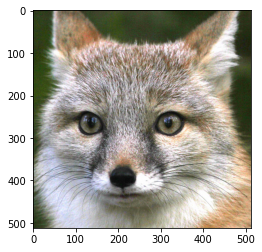

(512, 512, 3)


In [2]:
''' 

Created May 15, 2022
Neural Knitwork 
Written by Dr. Navid Kardan and Gwyn Gras-Usry

'''

import numpy as np
from jax import  random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import os, imageio
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import math

max_split_size_mb = 512
rand_key = random.PRNGKey(0)

# Download image, take a square crop from the center
image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
img = imageio.imread(image_url)[..., :3] / 255. # read an image from the specified url
c = [img.shape[0]//2, img.shape[1]//2]
r = 256
img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

plt.imshow(img)
plt.show()
print(img.shape)

#create np array with 3x3 patchs for every pixel coordinate 
patchs = np.zeros((img.shape[0], img.shape[1], 3, 3, 3))

#fill patches with values from image
for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    for k in range(-1, 2, 1):
      for m in range(-1, 2, 1):
        if i-k >= 0 and j-m >= 0:
          if i-k < img.shape[0] and j-m < img.shape[1]:
            patchs[i,j,k,m,:] = img[i-k,j-m,:]


# Create input pixel coordinates in the unit square
coords = np.linspace(0, 1, img.shape[0], endpoint=False) 
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [x_test, patchs]
x1, x2, y1, y2 = 250, 300, 200, 250

#remove block of pixels train data
train_data1 = [np.reshape(x_test[:x1:1,::1], (x1*512,2)), np.reshape(patchs[:x1:1,::1], (x1*512,3,3,3))]
train_data2 = [np.reshape(x_test[x1::1,:y1:1], ((512-x1)*y1, 2)), np.reshape(patchs[x1::1,:y1:1], ((512-x1)*y1, 3,3,3))]
train_data3 = [np.reshape(x_test[x1:x2:1,y2::1], ((x2-x1)*(512-y2), 2)), np.reshape(patchs[x1:x2:1,y2::1], ((x2-x1)*(512-y2), 3,3,3))]
train_data4 = [np.reshape(x_test[x2::1,y1::1], ((512-x2)*(512-y1), 2)), np.reshape(patchs[x2::1,y1::1], ((512-x2)*(512-y1), 3,3,3))]
train_data_input = np.concatenate([train_data1[0], train_data2[0], train_data3[0], train_data4[0]], 0)
train_data_output = np.concatenate([train_data1[1], train_data2[1], train_data3[1], train_data4[1]], 0)
train_data = [train_data_input, train_data_output]


# Fourier feature mapping
def input_mapping(x, B): 
  if B is None:
    return x
  else:
    x_proj = (2.*np.pi*x) @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)


#defines Patch MLP network
def make_network(num_layers, num_channels, input_channels): 
  layers = []
  layers.append(nn.Linear(input_channels, num_channels))
  layers.append(nn.ReLU())
  for i in range(num_layers-1):
    layers.append(nn.Linear(num_channels, num_channels))
    layers.append(nn.ReLU())
  layers.append(nn.Linear(num_channels, 3*3*3))
  layers.append(nn.Sigmoid())
  net = nn.Sequential(*layers)
  return net


#defines MLP reconstructor network
def make_network2(num_layers, num_channels, input_channels): 
  layers = []
  layers.append(nn.Linear(input_channels, num_channels))
  layers.append(nn.ReLU())
  for i in range(num_layers-1):
    layers.append(nn.Linear(num_channels, num_channels))
    layers.append(nn.ReLU())
  layers.append(nn.Linear(num_channels, 3))
  layers.append(nn.Sigmoid())
  net = nn.Sequential(*layers)
  return net


# Train model with given hyperparameters and data
def train_model(network_size, learning_rate, iters, B, train_data, test_data): 
  
  net = make_network(*network_size).cpu()
  
  criterion = nn.CrossEntropyLoss() 
  optimizer = optim.Adam(net.parameters(), lr=0.001) 

  pred_imgs = []
  xs = []
  for i in tqdm(range(iters), desc='train iter', leave=False):
      optimizer.zero_grad()
      net_output = net(torch.from_numpy(input_mapping(train_data[0], B))).cpu().float()
      loss = ((net_output.view(-1, 3, 3, 3) - torch.from_numpy(train_data[1]).cpu().float())**2).mean() #calculate MSE
      loss.backward()
      optimizer.step()
      if i % 25 == 0:
        print(loss)
        with torch.no_grad():
          test_image = net(torch.from_numpy(input_mapping(test_data[0], B)).cpu().float()).cpu()
          test_image = test_image[:, :, 12:15] #get test_image from patchs, take middle three RGB values 
          #calculate PSNR for inpainted region 
          x1, x2, y1, y2 = 250, 300, 200, 250
          MSE = ((test_image[x1:x2, y1:y2, :] - torch.from_numpy(test_data[1])[x1:x2, y1:y2, 0,0,:])**2).sum()/((x2-x1)*(y2-y1)*3)
          PSNR = 10*torch.log10(1**2/MSE)
          print('i: ', i)
          print('PSNR: ', PSNR)
          plt.imshow(test_image.numpy())
          plt.show()
  return net


def train_reconstructor(network_size, learning_rate, iters, B, train_data, test_data, patch_MLP): 
  
  net = make_network2(*network_size).cpu()
  
  optimizer = optim.Adam(net.parameters(), lr=0.001) 

  pred_imgs = []
  xs = []
  for i in tqdm(range(iters), desc='train iter', leave=False):
      optimizer.zero_grad()
      loss = (torch.abs(net(torch.from_numpy(train_data[1]).reshape((train_data[1].shape[0], 27)).cpu().float()) - torch.from_numpy(train_data[1]).reshape((train_data[1].shape[0], 27))[:,12:15].cpu().float())).mean() #MSE
      loss.backward()
      optimizer.step()
      if i % 25 == 0:
        print(loss)
        with torch.no_grad():
          test_image = net(patch_MLP(torch.from_numpy(input_mapping(test_data[0], B)).cpu().float()).cpu())
          plt.imshow(test_image.numpy())
          plt.show()
          #PSNR
          x1, x2, y1, y2 = 250, 300, 200, 250
          MSE = ((test_image[x1:x2, y1:y2, :] - torch.from_numpy(test_data[1])[x1:x2, y1:y2, 0,0,:])**2).sum()/((x2-x1)*(y2-y1)*3)
          PSNR = 10*torch.log10(1**2/MSE)
          print('i: ', i)
          print('PSNR: ', PSNR)


train iter:   0%|          | 0/201 [00:00<?, ?it/s]

tensor(0.0660, grad_fn=<MeanBackward0>)
i:  0
PSNR:  tensor(14.0525, dtype=torch.float64)


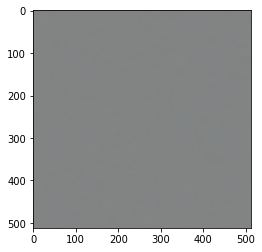

tensor(0.0299, grad_fn=<MeanBackward0>)
i:  25
PSNR:  tensor(14.9926, dtype=torch.float64)


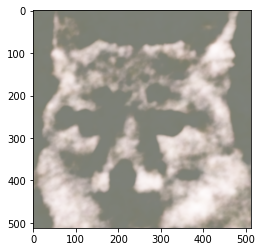

tensor(0.0088, grad_fn=<MeanBackward0>)
i:  50
PSNR:  tensor(15.7828, dtype=torch.float64)


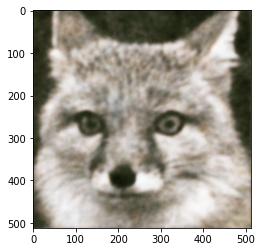

tensor(0.0072, grad_fn=<MeanBackward0>)
i:  75
PSNR:  tensor(15.9178, dtype=torch.float64)


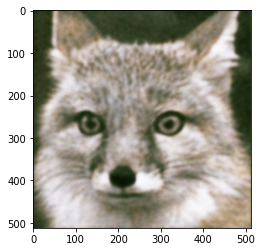

tensor(0.0066, grad_fn=<MeanBackward0>)
i:  100
PSNR:  tensor(15.9472, dtype=torch.float64)


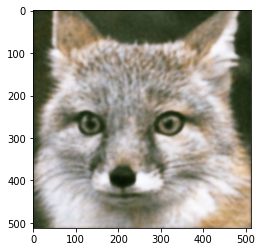

tensor(0.0060, grad_fn=<MeanBackward0>)
i:  125
PSNR:  tensor(15.9094, dtype=torch.float64)


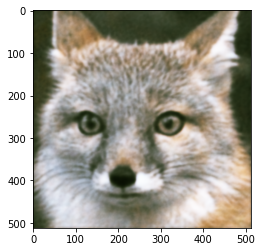

tensor(0.0057, grad_fn=<MeanBackward0>)
i:  150
PSNR:  tensor(15.8088, dtype=torch.float64)


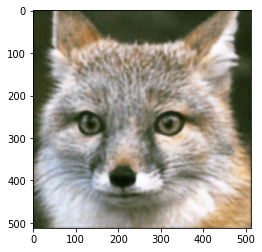

tensor(0.0057, grad_fn=<MeanBackward0>)
i:  175
PSNR:  tensor(15.7032, dtype=torch.float64)


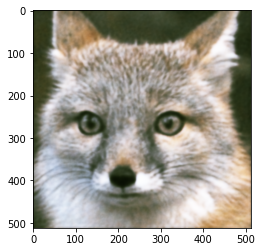

tensor(0.0055, grad_fn=<MeanBackward0>)
i:  200
PSNR:  tensor(15.6612, dtype=torch.float64)


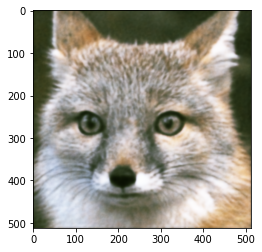

train iter:   0%|          | 0/201 [00:00<?, ?it/s]

tensor(0.2193, grad_fn=<MeanBackward0>)


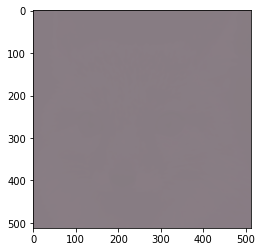

i:  0
PSNR:  tensor(14.0577, dtype=torch.float64)
tensor(0.1370, grad_fn=<MeanBackward0>)


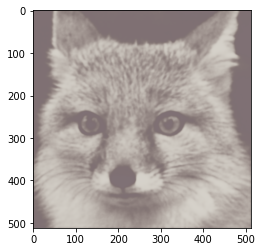

i:  25
PSNR:  tensor(16.4840, dtype=torch.float64)
tensor(0.0545, grad_fn=<MeanBackward0>)


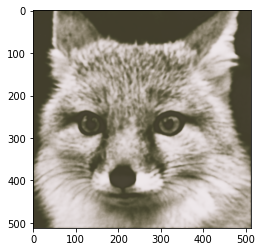

i:  50
PSNR:  tensor(14.8412, dtype=torch.float64)
tensor(0.0381, grad_fn=<MeanBackward0>)


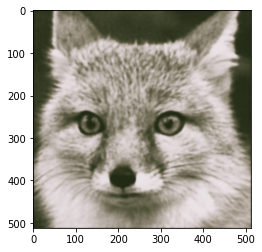

i:  75
PSNR:  tensor(15.4699, dtype=torch.float64)
tensor(0.0349, grad_fn=<MeanBackward0>)


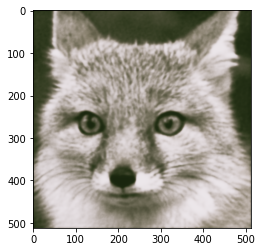

i:  100
PSNR:  tensor(15.5323, dtype=torch.float64)
tensor(0.0329, grad_fn=<MeanBackward0>)


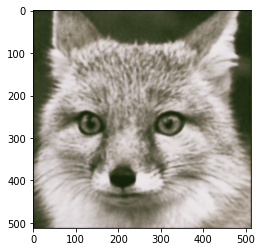

i:  125
PSNR:  tensor(15.5494, dtype=torch.float64)
tensor(0.0325, grad_fn=<MeanBackward0>)


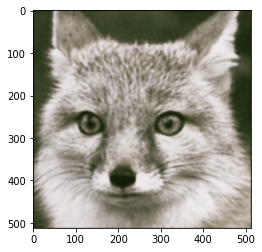

i:  150
PSNR:  tensor(15.5327, dtype=torch.float64)
tensor(0.0312, grad_fn=<MeanBackward0>)


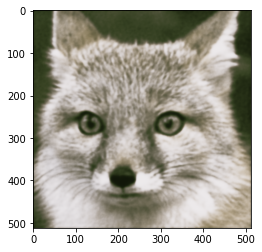

i:  175
PSNR:  tensor(15.5141, dtype=torch.float64)
tensor(0.0282, grad_fn=<MeanBackward0>)


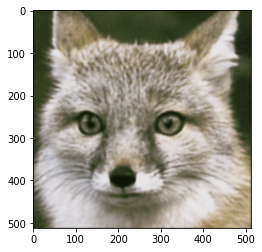

i:  200
PSNR:  tensor(15.4340, dtype=torch.float64)


In [3]:
#train the network

network_size = (4, 256)
learning_rate = 1e-4
iters = 201
mapping_size = 256

B_dict = {}
# Standard network - no mapping
B_dict['none'] = None
# Basic mapping
B_dict['basic'] = np.eye(2)
# Three different scales of Gaussian Fourier feature mappings
B_gauss = random.normal(rand_key, (mapping_size, 2))
for scale in [1., 10., 100.]:
  B_dict[f'gauss_{scale}'] = B_gauss * scale


#outputs = {}
net0 = train_model((4, 256, 512), learning_rate, iters, B_dict['gauss_10.0'], train_data, test_data)

train_reconstructor((4, 128 , 27), learning_rate, iters, B_dict['gauss_10.0'], train_data, test_data, net0)